In [28]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys

In [29]:
def plotThresholdsCurve(graph, curve, metric, percentiles):
    graph.plot(curve['LOC_weights_norm'], curve[metric], color='black')
    for percentile in percentiles:
        per = curve[curve['LOC_weights_norm'] >= percentile][metric].values[0]
        graph.plot(np.interp(per, curve[metric], curve['LOC_weights_norm']), per, marker='o', markersize=5, color='black')
        graph.text(np.interp(per, curve[metric], curve['LOC_weights_norm']) + 0.02, per-0.4, f'{per}', color='black', weight='bold')
    graph.set_title(f'Umbrales {metric}', weight='bold')
    graph.set_xlabel('Cuantiles')
    graph.set_ylim([1, curve[curve['LOC_weights_norm'] >= 0.95][metric].values[0]])
    
def plotSystemsDistribution(graph, entitiesAgg: pd.DataFrame, metric, painted=[]):
    projects = entitiesAgg['Repository'].unique()

    for project in projects:

        color = 'lightgrey'
        if project in painted:
            color = 'red'

        projectData = entitiesAgg[entitiesAgg['Repository'] == project]

        projectData = projectData.sort_values(by=metric)
        projectData['LOC_weights_cum'] = projectData['LOC_weights'].cumsum().to_frame()

        graph.plot(projectData['LOC_weights_cum'], projectData[metric], color=color)

    axis = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().to_frame()

    axis['cdf'] = axis['LOC_weights_norm'].cumsum()

    graph.plot(axis['cdf'], axis.index, color='black')
    
    graph.set_title(f'Umbrales por sistemas ({metric})', weight='bold')
    graph.set_xlabel('Cuantiles')
    graph.set_ylim([1, axis[axis['cdf'] >= 0.99].index.values[0]])

In [30]:
def generateAlvesThresholds(df, metric):
    # 1. Metrics Extraction
    total_loc = df.groupby('Repository')['LOC'].sum()
    df = df.join(total_loc, on='Repository', rsuffix='_total')

    # 2. Weight Ratio Calculation
    df['LOC_weights'] = df['LOC'] / (df['LOC_total'])

    # 3. Entity aggregation
    entitiesAgg = df.groupby(['Repository', metric])['LOC_weights'].sum().reset_index()

    # 4. System aggregation
    systems = total_loc.shape[0]
    entitiesAgg['LOC_weights_norm'] = entitiesAgg['LOC_weights']/systems
    systemAgg = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().reset_index()
    axis = systemAgg.copy()

    # 5. Weight Ratio Aggregation
    systemAgg = systemAgg.sort_values(by=metric)
    axis['LOC_weights_norm'] = systemAgg['LOC_weights_norm'].cumsum().to_frame()

    # 6. Thresholds derivaton
    p70 = axis[axis['LOC_weights_norm'] >= 0.7][metric].values[0]
    p80 = axis[axis['LOC_weights_norm'] >= 0.8][metric].values[0]
    p90 = axis[axis['LOC_weights_norm'] >= 0.9][metric].values[0]

    metricRow = pd.DataFrame([{'Metric': metric, '70th': p70, '80th': p80, '90th':p90}])
    return metricRow, axis, entitiesAgg

In [31]:
def systemsThresholds(entitiesAgg, metric):
    thresholds = pd.DataFrame()
    projects = entitiesAgg['Repository'].unique()
    
    for id in range(len(projects)):
        systemValues = entitiesAgg[entitiesAgg['Repository'] == projects[id]].copy()
        systemValues = systemValues.sort_values(by=metric)
        systemValues['LOC_weights_cum'] = systemValues['LOC_weights'].cumsum().to_frame()

        p70 = systemValues[systemValues['LOC_weights_cum'] >= 0.70][metric].values[0]
        p80 = systemValues[systemValues['LOC_weights_cum'] >= 0.80][metric].values[0]
        p90 = systemValues[systemValues['LOC_weights_cum'] >= 0.90][metric].values[0]
        systemThresholds = pd.DataFrame([{'System': projects[id], '70th': p70, '80th': p80, '90th': p90}])
        thresholds = pd.concat([thresholds, systemThresholds])
    
    return thresholds

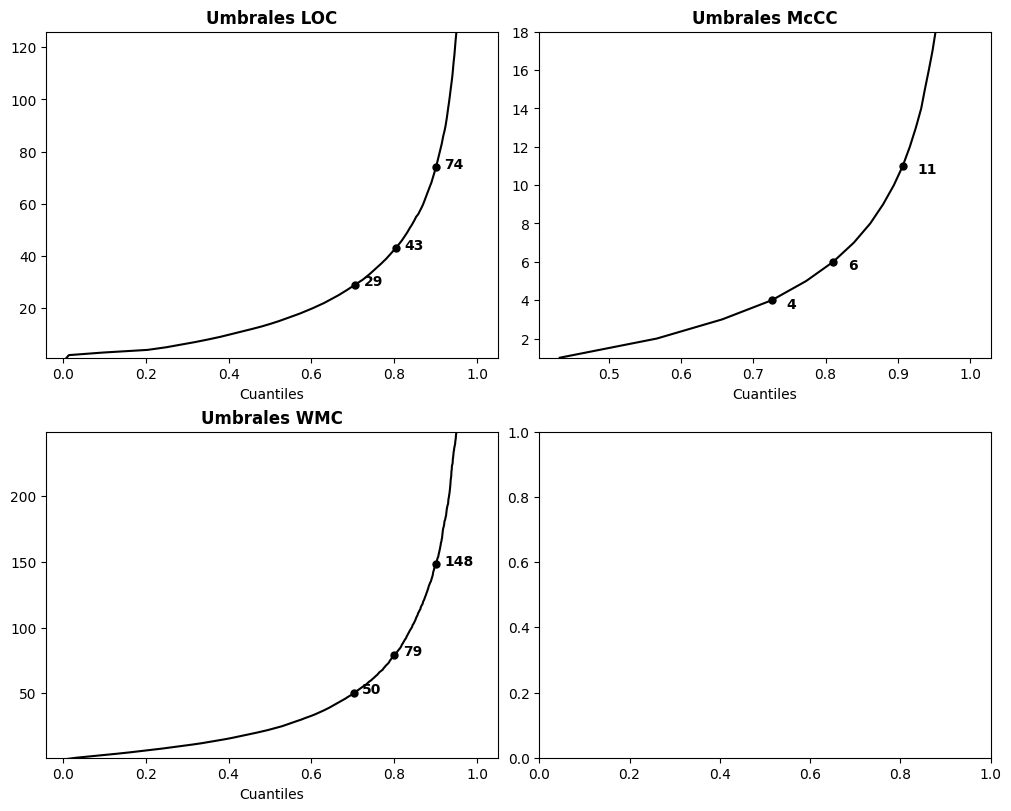

Number of projects: 112


Metric 70th 80th 90th
0    LOC   29   43   74
0   McCC    4    6   11
0    WMC   50   79  148

In [32]:
datasetPath = './datasets/caseStudy/currentSample/'
metrics = {'method': ['LOC', 'McCC'], 'class': ['WMC']}
metricCount = 0
for level in metrics:
    metricCount += len(metrics[level])

datasets = {}
results = pd.DataFrame(columns=['Metric', '70th', '80th', '90th'])
fig, axs = plt.subplots(2,2, figsize=(10, 4*2), constrained_layout = True)
i=0
j=0

for level in metrics:
    dataset = pd.read_csv(f'{datasetPath}/{level}.csv')
    datasets[level] = dataset

    for metric in metrics[level]:
        thresholds, curves, _ = generateAlvesThresholds(datasets[level], metric)
        plotThresholdsCurve(axs[i,j], curves, metric, [0.7, 0.8, 0.9])
        j+=1
        results = pd.concat([results, thresholds]) 
    j=0 
    i+=1      
        
plt.show()
print(f'Number of projects: {datasets["class"]["Repository"].nunique()}')
results

# Outliers detection


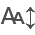

LOC


System  70th  \
0                                 https://github.com/stripe/stripe-java     7   
0                     https://github.com/aliyun/aliyun-openapi-java-sdk     6   
0                        https://github.com/spring-projects/spring-boot    11   
0                                  https://github.com/junit-team/junit5    12   
0                       https://github.com/approvals/ApprovalTests.Java    14   
0                                          https://github.com/jdbi/jdbi    12   
0                                 https://github.com/dromara/dynamic-tp    14   
0                                         https://github.com/Hack23/cia    11   
0                                     https://github.com/yegor256/takes    18   
0                                 https://github.com/domaframework/doma    13   
0                               https://github.com/cloudfoundry/credhub    20   
0                                https://github.com/tinylog-org/tinylog    13   
0                                 https://github.com/apache/streampipes    17   
0                           https://github.com/saucelabs/saucerest-java    17   
0                                https://github.com/miso-lims/miso-lims    14   
0                            https://github.com/scm-manager/scm-manager    18   
0                                       https://github.com/google/guava    16   
0                                       https://github.com/gchq/sleeper    18   
0                                        https://github.com/neo4j/neo4j    18   
0                               https://github.com/android/android-test    20   
0                https://github.com/spring-cloud/spring-cloud-openfeign    18   
0              https://github.com/aws-powertools/powertools-lambda-java    28   
0                           https://github.com/Suwayomi/Suwayomi-Server    17   
0                                   https://github.com/ls1intum/Artemis    24   
0                   https://github.com/commons-app/apps-android-commons    24   
0                                 https://github.com/twilio/twilio-java    32   
0                        https://github.com/apache/incubator-streampark    26   
0                          https://github.com/graphql-java/graphql-java    18   
0                               https://github.com/scalar-labs/scalardb    21   
0                                https://github.com/TencentCloud/TIMSDK    22   
0                                 https://github.com/eclipse/chemclipse    23   
0                                     https://github.com/grpc/grpc-java    24   
0                        https://github.com/schemacrawler/SchemaCrawler    27   
0                                  https://github.com/Convex-Dev/convex    23   
0                             https://github.com/hs-web/hsweb-framework    22   
0                                        https://github.com/yahoo/elide    26   
0                             https://github.com/TencentBlueKing/bk-job    31   
0  https://github.com/open-telemetry/opentelemetry-java-instrumentation    23   
0                              https://github.com/ManyDesigns/Portofino    25   
0                            https://github.com/confluentinc/kafka-rest    25   
0                          https://github.com/apache/incubator-baremaps    23   
0                                   https://github.com/telekom/testerra    16   
0                      https://github.com/firebase/firebase-android-sdk    27   
0                                      https://github.com/rsksmart/rskj    24   
0                           https://github.com/OpenTracksApp/OpenTracks    29   
0                      https://github.com/eclipse-jdt/eclipse.jdt.debug    35   
0                                      https://github.com/FabricMC/yarn    27   
0                 https://github.com/testcontainers/testcontainers-java    23   
0                                      https://github.com/flyway/flyway    24   
0              

McCC


System  70th  \
0                     https://github.com/aliyun/aliyun-openapi-java-sdk     2   
0                                 https://github.com/stripe/stripe-java     2   
0                                         https://github.com/Hack23/cia     1   
0                             https://github.com/MarquezProject/marquez     2   
0                                     https://github.com/yegor256/takes     2   
0                    https://github.com/portfolio-performance/portfolio     1   
0                                 https://github.com/apache/streampipes     2   
0                            https://github.com/confluentinc/kafka-rest     2   
0                                       https://github.com/gchq/sleeper     2   
0                                       https://github.com/google/guava     2   
0                                          https://github.com/jdbi/jdbi     2   
0                                  https://github.com/junit-team/junit5     2   
0  https://github.com/open-telemetry/opentelemetry-java-instrumentation     2   
0                            https://github.com/scm-manager/scm-manager     2   
0                        https://github.com/spring-projects/spring-boot     2   
0                                      https://github.com/FabricMC/yarn     3   
0                       https://github.com/approvals/ApprovalTests.Java     3   
0                                      https://github.com/magefree/mage     1   
0                                 https://github.com/domaframework/doma     2   
0                                        https://github.com/google/j2cl     2   
0                                https://github.com/miso-lims/miso-lims     2   
0                               https://github.com/android/android-test     2   
0                                 https://github.com/dromara/dynamic-tp     2   
0                               https://github.com/cloudfoundry/credhub     3   
0              https://github.com/aws-powertools/powertools-lambda-java     3   
0                                 https://github.com/eclipse/chemclipse     3   
0                      https://github.com/firebase/firebase-android-sdk     3   
0                                        https://github.com/neo4j/neo4j     3   
0                               https://github.com/scalar-labs/scalardb     3   
0                 https://github.com/testcontainers/testcontainers-java     3   
0                           https://github.com/OpenTracksApp/OpenTracks     3   
0                   https://github.com/commons-app/apps-android-commons     3   
0                           https://github.com/saucelabs/saucerest-java     1   
0                          https://github.com/graphql-java/graphql-java     3   
0                                   https://github.com/arianne/stendhal     3   
0                              https://github.com/cBioPortal/cbioportal     3   
0                https://github.com/spring-cloud/spring-cloud-openfeign     3   
0                                https://github.com/tinylog-org/tinylog     3   
0                          https://github.com/apache/incubator-baremaps     4   
0                        https://github.com/apache/incubator-streampark     4   
0                                   https://github.com/ls1intum/Artemis     4   
0                                      https://github.com/rsksmart/rskj     4   
0                        https://github.com/schemacrawler/SchemaCrawler     4   
0                                        https://github.com/yahoo/elide     4   
0                             https://github.com/TencentBlueKing/bk-job     4   
0                                 https://github.com/Slimefun/Slimefun4     5   
0                                   https://github.com/telekom/testerra     3   
0                                 https://github.com/twilio/twilio-java     4   
0                             https://github.com/hs-web/hsweb-framework     3   
0              

WMC


System  70th  \
0                                      https://github.com/FabricMC/yarn     8   
0                                     https://github.com/yegor256/takes    12   
0                               https://github.com/cloudfoundry/credhub    16   
0                                      https://github.com/magefree/mage     7   
0                                       https://github.com/gchq/sleeper    18   
0              https://github.com/aws-powertools/powertools-lambda-java    20   
0                                 https://github.com/apache/streampipes    16   
0                            https://github.com/confluentinc/kafka-rest    16   
0  https://github.com/open-telemetry/opentelemetry-java-instrumentation    15   
0                            https://github.com/scm-manager/scm-manager    17   
0                             https://github.com/MarquezProject/marquez    24   
0                                 https://github.com/stripe/stripe-java    14   
0                     https://github.com/aliyun/aliyun-openapi-java-sdk    24   
0                          https://github.com/apache/incubator-baremaps    29   
0                           https://github.com/saucelabs/saucerest-java    22   
0                            https://github.com/Mindgamesnl/OpenAudioMc    20   
0                        https://github.com/spring-projects/spring-boot    22   
0                             https://github.com/hs-web/hsweb-framework    24   
0                                 https://github.com/twilio/twilio-java    36   
0                        https://github.com/schemacrawler/SchemaCrawler    28   
0                 https://github.com/testcontainers/testcontainers-java    38   
0                                 https://github.com/eclipse/chemclipse    29   
0                               https://github.com/android/android-test    23   
0                                  https://github.com/MCreator/MCreator    31   
0                                     https://github.com/grpc/grpc-java    30   
0                                   https://github.com/arianne/stendhal    27   
0                        https://github.com/syncthing/syncthing-android    67   
0                             https://github.com/matsim-org/matsim-libs    35   
0                       https://github.com/espressif/idf-eclipse-plugin    32   
0                        https://github.com/apache/incubator-streampark    36   
0                           https://github.com/SkyblockerMod/Skyblocker    33   
0                                 https://github.com/domaframework/doma    34   
0                           https://github.com/OpenTracksApp/OpenTracks    39   
0                       https://github.com/approvals/ApprovalTests.Java    49   
0                                     https://github.com/mzmine/mzmine3    52   
0                                          https://github.com/jdbi/jdbi    23   
0                                 https://github.com/dromara/dynamic-tp    23   
0                         https://github.com/Layers-of-Railways/Railway    31   
0                                        https://github.com/yahoo/elide    37   
0                    https://github.com/MeteorDevelopment/meteor-client    46   
0                                        https://github.com/neo4j/neo4j    43   
0                      https://github.com/firebase/firebase-android-sdk    49   
0                             https://github.com/TencentBlueKing/bk-job    44   
0                              https://github.com/cBioPortal/cbioportal    26   
0                                 https://github.com/Slimefun/Slimefun4    32   
0                              https://github.com/openremote/openremote    52   
0                                   https://github.com/ls1intum/Artemis    45   
0                              https://github.com/ManyDesigns/Portofino    56   
0                                  https://github.com/Protelis/Protelis    81   
0              

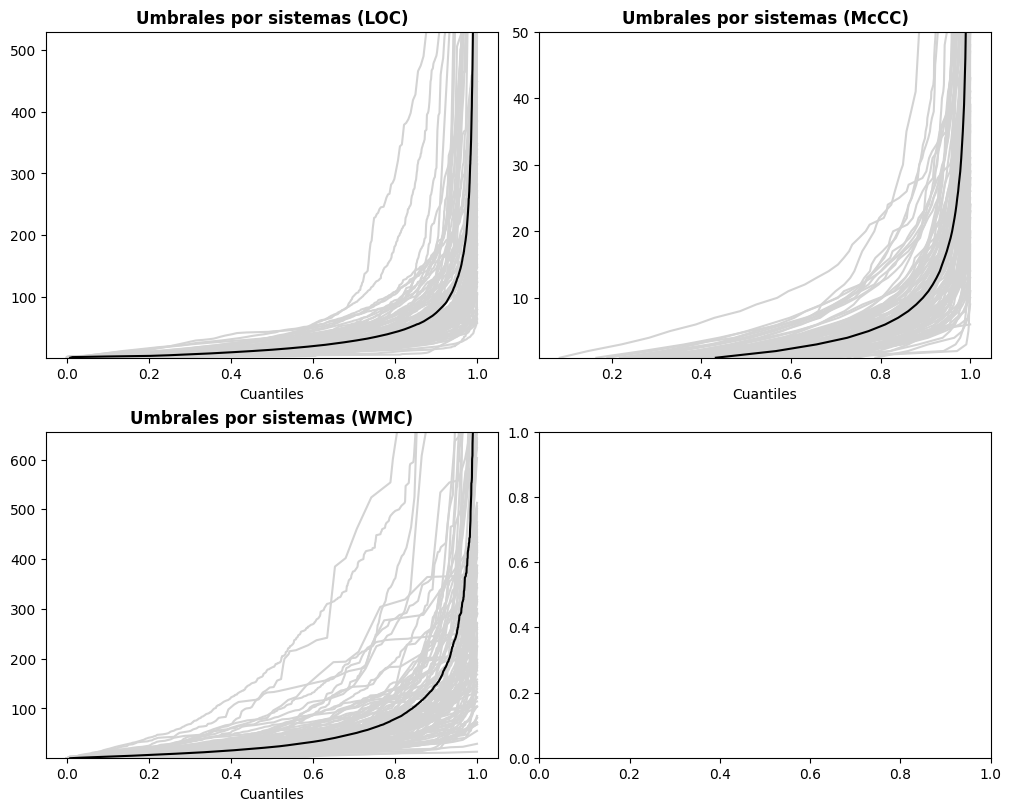

In [33]:
from scipy.spatial.distance import jensenshannon
from itables import init_notebook_mode

init_notebook_mode(all_interactive=True)
outliers = ['https://github.com/eclipse/xtext', 'https://github.com/SemanticApplicationDesignLanguage/sadl']

fig, axs = plt.subplots(2,2, figsize=(10, 4*2), constrained_layout = True)
i=0
j=0

for level in metrics:
    for metric in metrics[level]:
        _, _, entitiesAgg = generateAlvesThresholds(datasets[level], metric)
        results = systemsThresholds(entitiesAgg, metric)
        results = results.sort_values(by=['90th', '80th', '70th'])
        js_score = []

        for id, project in results.iterrows():
            projectProbDist = entitiesAgg[entitiesAgg['Repository'] == project['System']].reset_index()[[metric, 'LOC_weights']]
            datasetProbDist = entitiesAgg.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]           
        
            dfs = pd.merge(projectProbDist, datasetProbDist, on=metric, how='outer')[[metric, 'LOC_weights', 'LOC_weights_norm']]
            dfs.rename(columns={'LOC_weights': 'outlier', 'LOC_weights_norm': "sample"}, inplace=True)
            dfs.fillna(0, inplace=True)

            dfs = dfs.sort_values(metric)
            js_score.append(jensenshannon(dfs["sample"], dfs["outlier"]))

        results['js_score'] = js_score
            

        print(metric)
        with pd.option_context('display.max_rows', None, 'display.max_columns', None, 'display.max_colwidth', None):
            display(results) 

        plotSystemsDistribution(axs[i,j], entitiesAgg, metric, outliers)
        j+=1

    j=0
    i+=1

plt.show()

# REPLACE OUTLIERS

In [ ]:
from main import replaceOutliers

population = pd.read_csv('./datasets/caseStudy/frame.csv')

replaceOutliers(population, datasetPath, outliers, './SourceMeter', './SourceMeter/repos')

COSINE SIMILARITY


-------->LOC

KS = {'ks-statistic': 0.12420382165605096, 'p-value': 9.483666962119354e-07, 'sign': -1}
KS = {'ks-statistic': 0.01167728237791932, 'p-value': 0.9999999578871422, 'sign': 1}
JS = 0.15986397403031696
JS = 0.09262607258469645

-------->McCC

KS = {'ks-statistic': 0.12131147540983607, 'p-value': 0.02239206976927056, 'sign': -1}
KS = {'ks-statistic': 0.022950819672131147, 'p-value': 0.9999983401742578, 'sign': 1}
JS = 0.13205337714986617
JS = 0.05629400650796448

-------->WMC

KS = {'ks-statistic': 0.11334120425029516, 'p-value': 3.700110021185316e-05, 'sign': -1}
KS = {'ks-statistic': 0.012987012987012988, 'p-value': 0.9999997210447596, 'sign': 1}
JS = 0.21273760587197235
JS = 0.1577718037740661


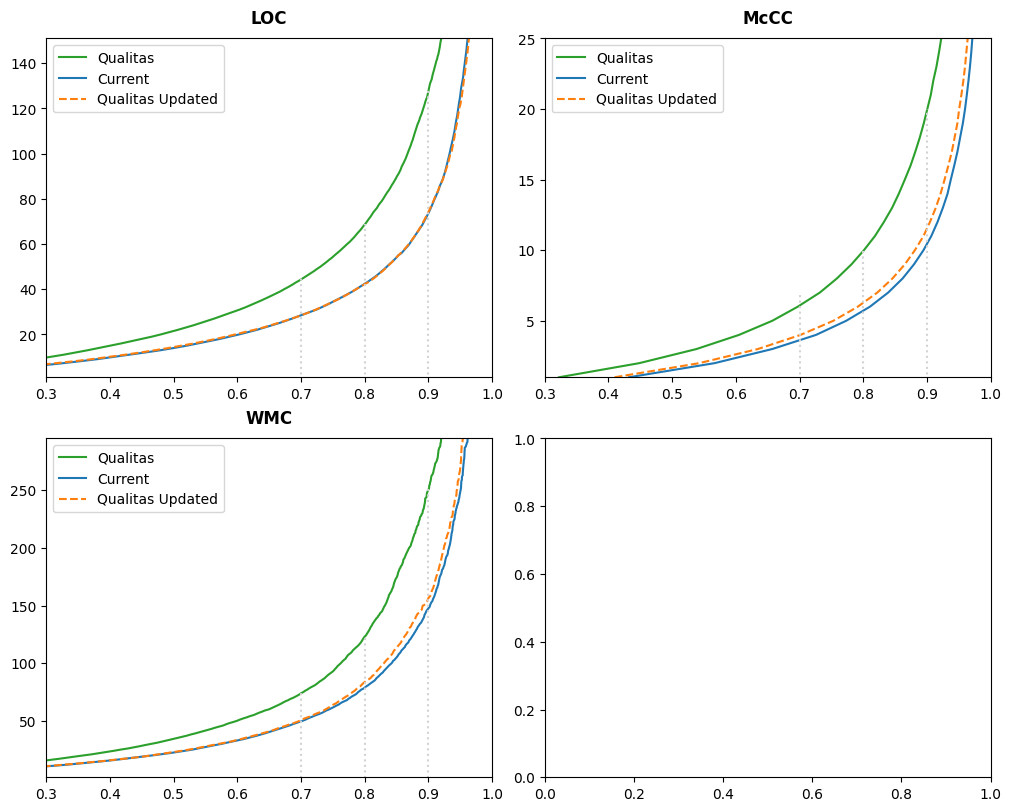

In [34]:
from ks2sampCDF import ks_2sampCDF
from scipy.spatial.distance import jensenshannon

methodDim = ['LOC', 'McCC']
classDim = ['WMC']
metricTitles = ["LOC", "McCC", "WMC"]

folders = ['qualitas', 'currentSample', 'qualitasUpdated']
legends = ['Qualitas','Current', 'Qualitas Updated']
lineStyles = ['-', '-', '--']
lineColors = ['#2ca02c', '#1f77b4', '#ff7f0e']
classSamples = []
methodSamples = []
dims = len(methodDim) + len(classDim)

fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)


for sample in folders:
    classSample = pd.read_csv(f'./datasets/caseStudy/{sample}/class.csv')
    classSamples.append(classSample)

    methodSample = pd.read_csv(f'./datasets/caseStudy/{sample}/method.csv')
    methodSamples.append(methodSample)


def plotting(dimensions, typeSamples, i):
    k=0
    for metric in dimensions:

        table = pd.DataFrame(columns=['Metric', '70th', '80th', '90th'])

        print(f'\n-------->{metric}\n')

        thresholds = []
        nSamples = len(folders)

        for j in range(nSamples):

            _, _, agg = generateAlvesThresholds(typeSamples[j], metric)
            sys = agg.groupby(metric)['LOC_weights_norm'].sum().reset_index()[[metric, 'LOC_weights_norm']]
            sys.rename(columns={'LOC_weights_norm': folders[j]}, inplace=True)
            thresholds.append(sys)


        dfs = pd.merge(thresholds[0], thresholds[1], on=metric, how='outer')
        dfs = pd.merge(dfs, thresholds[2], on=metric, how='outer')
        dfs.fillna(0, inplace=True)

        dfs = dfs.sort_values(metric)

        for j in range(nSamples):

            dfs[f'cdf_{folders[j]}'] = dfs[folders[j]].cumsum()
            axs[i, k].plot(dfs[f'cdf_{folders[j]}'], dfs[metric], linestyle=lineStyles[j], color=lineColors[j])

        axs[i, k].legend(legends)

        lim = dfs[dfs['cdf_qualitas'] >= 0.92][metric].values[0]

        axs[i, k].set_ylim(1, lim)
        axs[i, k].set_xlim(0.3, 1)

        axs[i, k].set_title(metricTitles[i*2 + k], weight="bold", y=1.02)
        axs[i, k].plot([0.7, 0.7], [0, dfs[dfs['cdf_qualitas'] >= 0.7][metric].values[0]], linestyle=':', color= 'lightgrey')
        axs[i, k].plot([0.8, 0.8], [0, dfs[dfs['cdf_qualitas'] >= 0.8][metric].values[0]], linestyle=':', color= 'lightgrey')
        axs[i, k].plot([0.9, 0.9], [0, dfs[dfs['cdf_qualitas'] >= 0.9][metric].values[0]], linestyle=':', color= 'lightgrey')

        k+=1

        print(f'KS = {ks_2sampCDF(dfs[f"cdf_{folders[0]}"], dfs[f"cdf_{folders[1]}"], method="exact")}')
        print(f'KS = {ks_2sampCDF(dfs[f"cdf_{folders[1]}"], dfs[f"cdf_{folders[2]}"], method="exact")}')
        print(f'JS = {jensenshannon(dfs[f"{folders[0]}"], dfs[f"{folders[1]}"])}')
        print(f'JS = {jensenshannon(dfs[f"{folders[1]}"], dfs[f"{folders[2]}"])}')

plotting(methodDim, methodSamples, 0)
plotting(classDim, classSamples, 1)

plt.show()


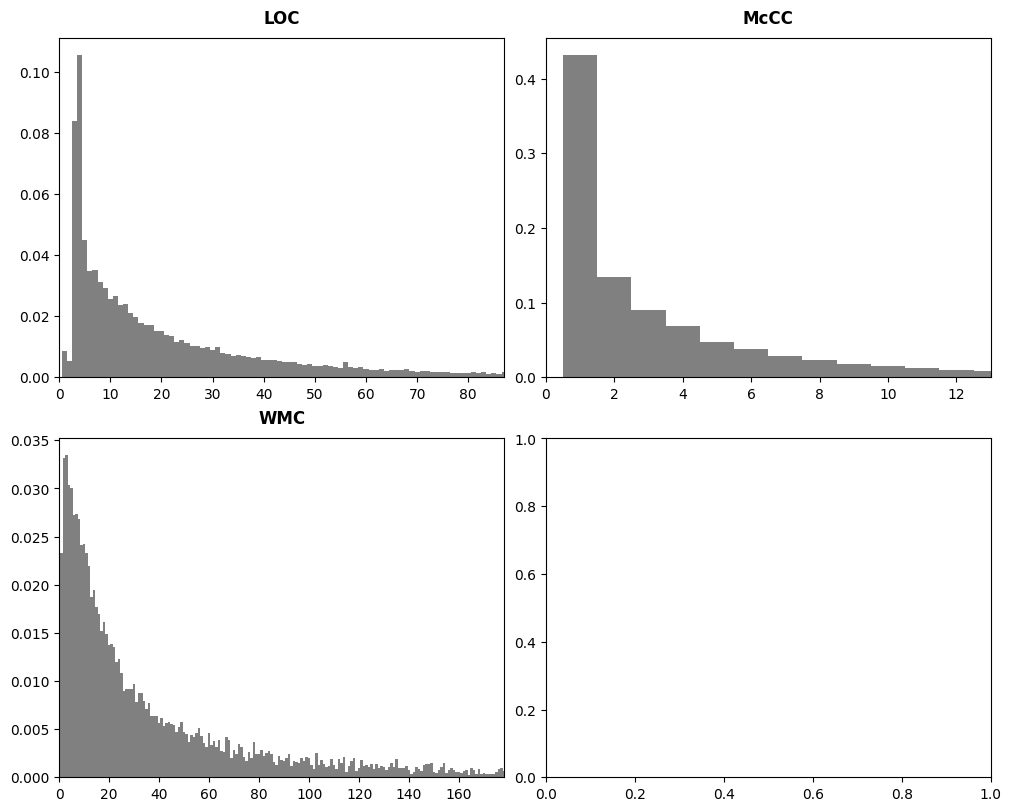

In [36]:
descStats = pd.DataFrame()
methodDim = ['LOC', 'McCC']
classDim = ['WMC']
metricTitles = ["LOC", "McCC", "WMC"]
folder = 'currentSample'

fig, axs = plt.subplots(2, 2, figsize=(10, 8), constrained_layout = True)

classSample = pd.read_csv(f'./datasets/caseStudy/{folder}/class.csv')
methodSample = pd.read_csv(f'./datasets/caseStudy/{folder}/method.csv')

def plotting(dimensions, sample, i):
    j = 0
    for dimension in dimensions:

        _, _, agg = generateAlvesThresholds(sample, dimension)
        sys = agg.groupby(dimension)['LOC_weights_norm'].sum().reset_index()[[dimension, 'LOC_weights_norm']]

        dfs = sys.sort_values(dimension)
        dfs['cdf'] = dfs['LOC_weights_norm'].cumsum()
        lim = dfs[dfs['cdf'] >= 0.92][dimension].values[0]
        axs[i,j].set_xlim((0, lim))
        axs[i, j].set_title(dimension, weight="bold", y=1.02)

        axs[i,j].bar(dfs[dimension], dfs['LOC_weights_norm'], width=1, color='grey')

        j += 1
      

plotting(methodDim, methodSample, 0)
plotting(classDim, classSample, 1)
